In [1]:
# Read csv file 
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Library imports

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', 
        palette='muted', 
        font_scale=1.5)
from pylab import rcParams
rcParams['figure.figsize'] = 14,8

import warnings
warnings.filterwarnings('ignore')

### Dataframe loading

The dataset from EU cardholders, contains data that occurred over a two day period

All variables are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The 3 attributes that have not been transformed are:

* Time - seconds elapsed between transactions
* Amount - transaction amount
* Class - response variable


In [3]:
linkwhite='https://drive.google.com/open?id=1ikdX1Ld5hucnqUXDx5xHbqZaS0U9hvBl'
fluff, id2 = linkwhite.split('=')
print (id2)

downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('creditcard.csv')  
dataset = pd.read_csv('creditcard.csv')
dataset.head()

1ikdX1Ld5hucnqUXDx5xHbqZaS0U9hvBl


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df = dataset.copy()

In [5]:
# Dimension
print('Rows     :', df.shape[0])
print('Columns  :', df.shape[1])

Rows     : 284807
Columns  : 31


## Visualize

In [6]:
# Preview any missing values
df.isnull().values.any()

False

In [7]:
corr = df.corr()

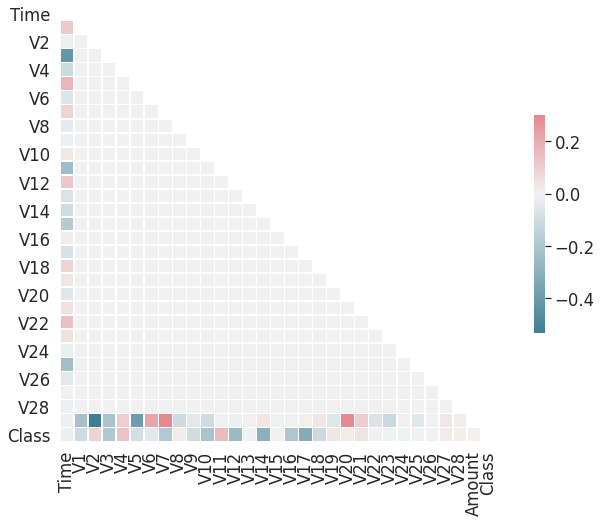

In [8]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Setup matplotlib figure
fig, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmax=.3, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={'shrink': .5}
)

### Response variable distribution

In [9]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [10]:
rsp_classes = ['Genuine', 'Fraud']

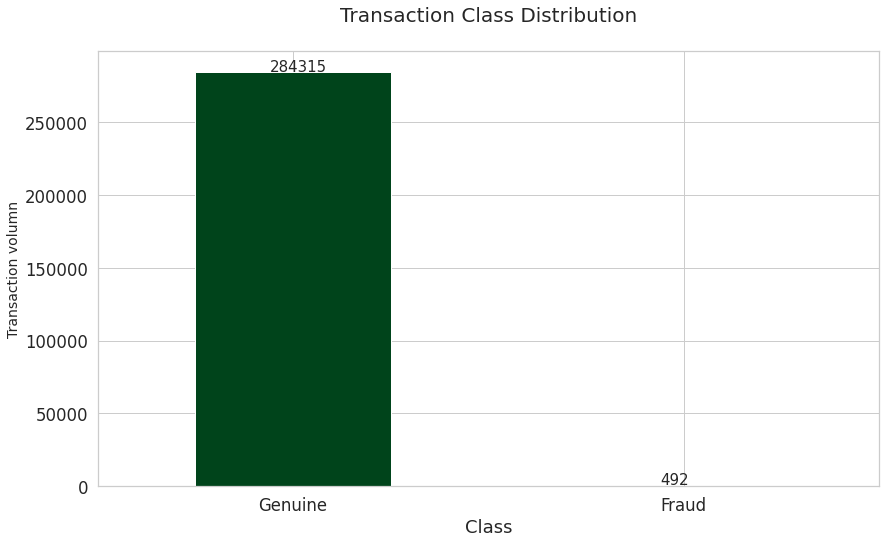

In [11]:
ax = df['Class'].value_counts().plot(kind='bar', rot=0, colormap='Greens_r')
plt.xticks(range(2), rsp_classes)
ax.set_title('Transaction Class Distribution', size=20, pad=30)
ax.set_ylabel('Transaction volumn', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Transaction volumn')

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)

Our dataframe is largely imbalanced. *Genuine* transactions exceeds *Fraudulent* transactions

In [12]:
# Transaction types
genuine = df[df.Class == 0]
fraud = df[df.Class == 1]

How different is the "Amount" variable used in different transaction classes?

In [13]:
genuine.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [14]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

A graphical representation of "Amount" variable

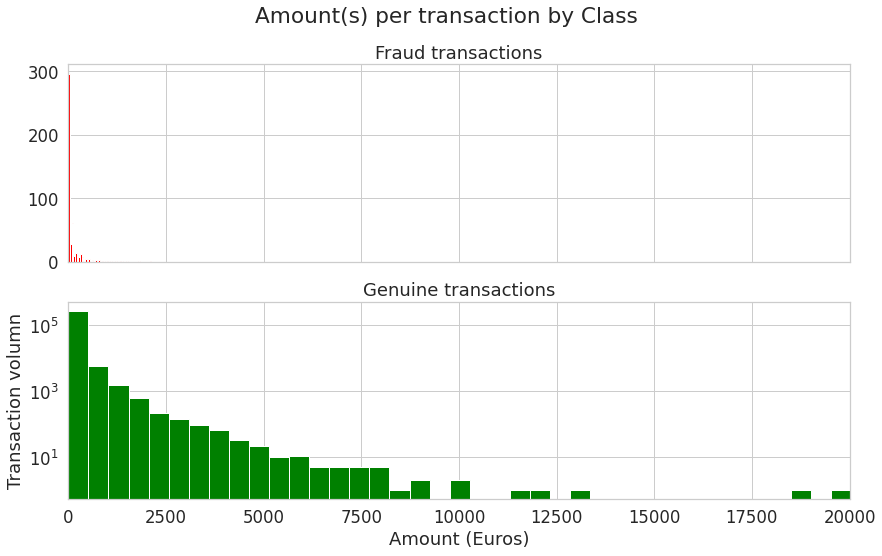

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.suptitle('Amount(s) per transaction by Class')

bins = 50

ax1.hist(fraud.Amount, bins=bins, color='red')
ax1.set_title('Fraud transactions')

ax2.hist(genuine.Amount, bins=bins, color='green')
ax2.set_title('Genuine transactions')

plt.xlabel('Amount (Euros)')
plt.ylabel('Transaction volumn')
plt.xlim(0, 20000)
plt.yscale('log')
plt.show()

Do fraudulent transactions occur more often during certain time?

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.suptitle('Time of transaction Vs Amount by Class')

ax1.scatter(fraud.Time, fraud.Amount, color='red')
ax1.set_title('Fraud transactions')

ax2.scatter(genuine.Time, genuine.Amount, color='green')
ax2.set_title('Genuine transactions')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount (Euros)')
plt.show()

Appears that the "Time" variable of transactions are meaningless

## Data preparation
### Drop variable

In [ ]:
# Drop unnecessary variable "Time"
to_drop = ['Time']
data = df.drop(['Time'], axis=1)

### Feature scaling
Normalized input vectors, for training data for our model to fall into the range [0, 1]

In [ ]:
from sklearn.preprocessing import StandardScaler

# StandardScaler on the "Amount" variable
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

### Machine learning without SMOTE

In [ ]:
from sklearn.model_selection import train_test_split

X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

# Train
rf = RandomForestClassifier(random_state=123)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues', 
    xticklabels=rsp_classes,
    yticklabels=rsp_classes
    )

plt.title('Confusion Matrix (without SMOTE)')
plt.ylabel('Prediction class')
plt.xlabel('Actual class')
plt.show()

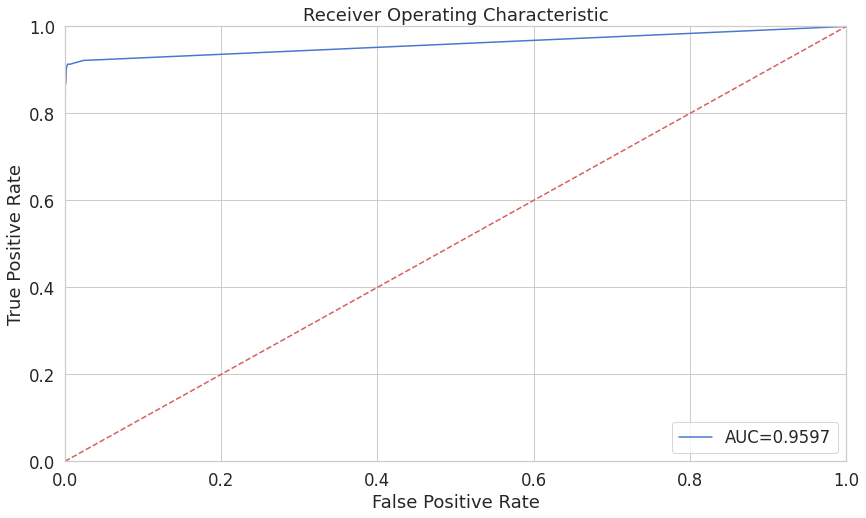

In [21]:
import sklearn.metrics as metrics

# Calculate fpr and tpr for all thresholds of the classification
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC=%0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Machine learning with SMOTE

In [22]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=123)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')

Shape of X before SMOTE: (284807, 29)
Shape of X after SMOTE: (568630, 29)


Accuracy = 1.00
Recall = 1.00



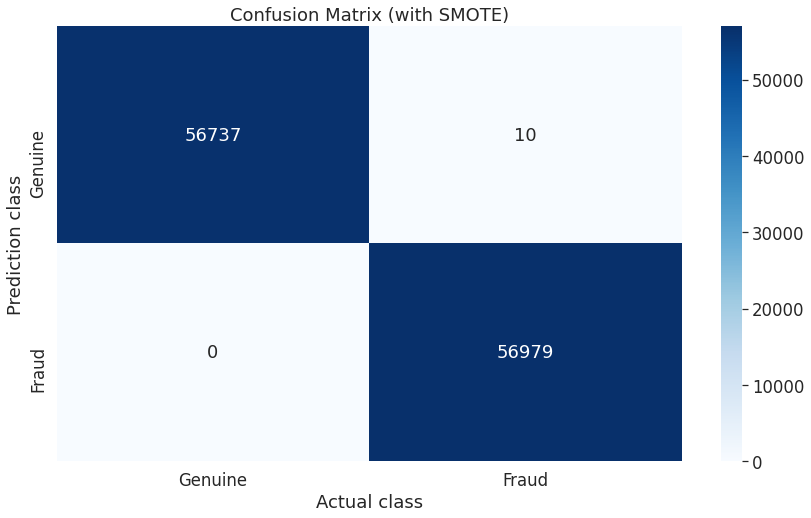

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=123
)

rf = RandomForestClassifier(random_state=123)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nRecall = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure()
sns.heatmap(
    cm, 
    annot=True,
    fmt='d', 
    cmap='Blues',
    xticklabels=rsp_classes,
    yticklabels=rsp_classes
)

plt.title('Confusion Matrix (with SMOTE)')
plt.ylabel('Prediction class')
plt.xlabel('Actual class')
plt.show()

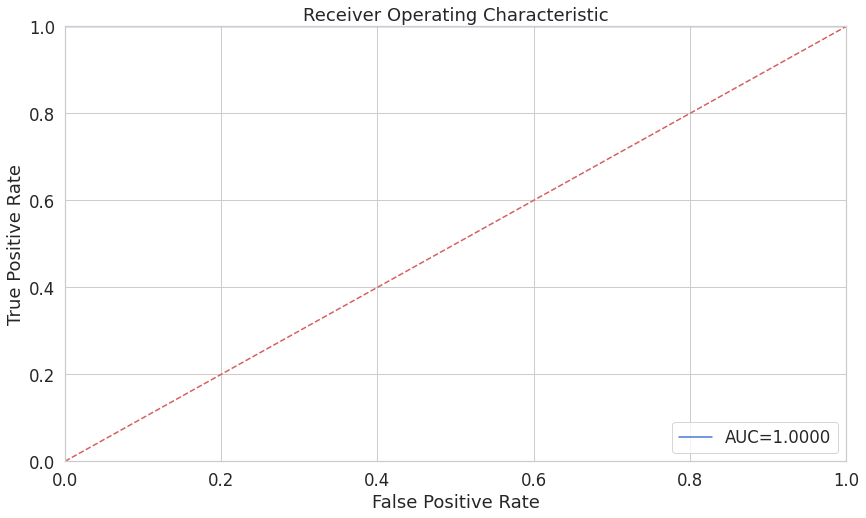

In [24]:
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC=%0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()